# Import Necessary Packages

In [180]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import glob
import matplotlib.pyplot as plt
import random

# Organize and PreProcess Images

In [78]:
# Makes new folders with training/validation data if they don't already exist
os.chdir('DS22/malaria-detection/cell_images')
if os.path.isdir('train/Uninfected') is False:
    os.makedirs('train/Uninfected')
    os.makedirs('train/Parasitized')
    os.makedirs('test/Uninfected')
    os.makedirs('test/Parasitized')
    for i in random.sample(glob.glob('Uninfected/*'), 7235):
        shutil.move(i, 'train/Uninfected')      
    for i in random.sample(glob.glob('Parasitized/*'), 7235):
        shutil.move(i, 'train/Parasitized')
    for i in random.sample(glob.glob('Uninfected/*'), 3444):
        shutil.move(i, 'test/Uninfected')        
    for i in random.sample(glob.glob('Parasitized/*'), 3444):
        shutil.move(i, 'test/Parasitized')

In [79]:
# Confirm correct sizes
print(len(os.listdir('train/Uninfected')))
print(len(os.listdir('train/Parasitized')))
print(len(os.listdir('test/Uninfected')))
print(len(os.listdir('test/Parasitized')))

10335
10335
3444
3444


In [231]:
train_path = 'train'
test_pth = 'test'

generator = ImageDataGenerator(validation_split = 0.20,
                               rotation_range = 30,
                               rescale=1/255,
                               shear_range = 0.01,
                               zoom_range = 0.01,
                               horizontal_flip = True)

t_generator = ImageDataGenerator(width_shift_range = 0.10,
                               rotation_range = 30,
                               shear_range = 0.01,
                               zoom_range = 0.01,
                               rescale=1/255,
                               horizontal_flip = True)

train_generator = generator.flow_from_directory(
        train_path,
        classes = ['Uninfected', 'Parasitized'],
        target_size=(224, 224),
        batch_size=20,
        subset = 'training',
        seed = 42,
        class_mode='binary')

val_generator = generator.flow_from_directory(
        train_path,
        classes = ['Uninfected', 'Parasitized'],
        target_size=(224, 224),
        batch_size=20,
        subset = 'validation',
        class_mode='binary')

test_generator = t_generator.flow_from_directory(
        test_pth,
        classes = ['Uninfected', 'Parasitized'],
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary',
        shuffle = False)

Found 16536 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.
Found 6888 images belonging to 2 classes.


In [232]:
imgs, labels = next(train_generator)

In [233]:
def showImages(images_arr, labels):
    fig, axes = plt.subplots(4, 5, figsize=(20,20))
    axes = axes.flatten()
    r = 0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = labels[0 + r]
        if label == 0:
            title = 'Uninfected'
        else:
            title = 'Parasitized'
        ax.set_title(title, fontsize=20)
        r +=1
    plt.tight_layout(pad=0.4, )
    plt.show()

# Let's look at some example images:

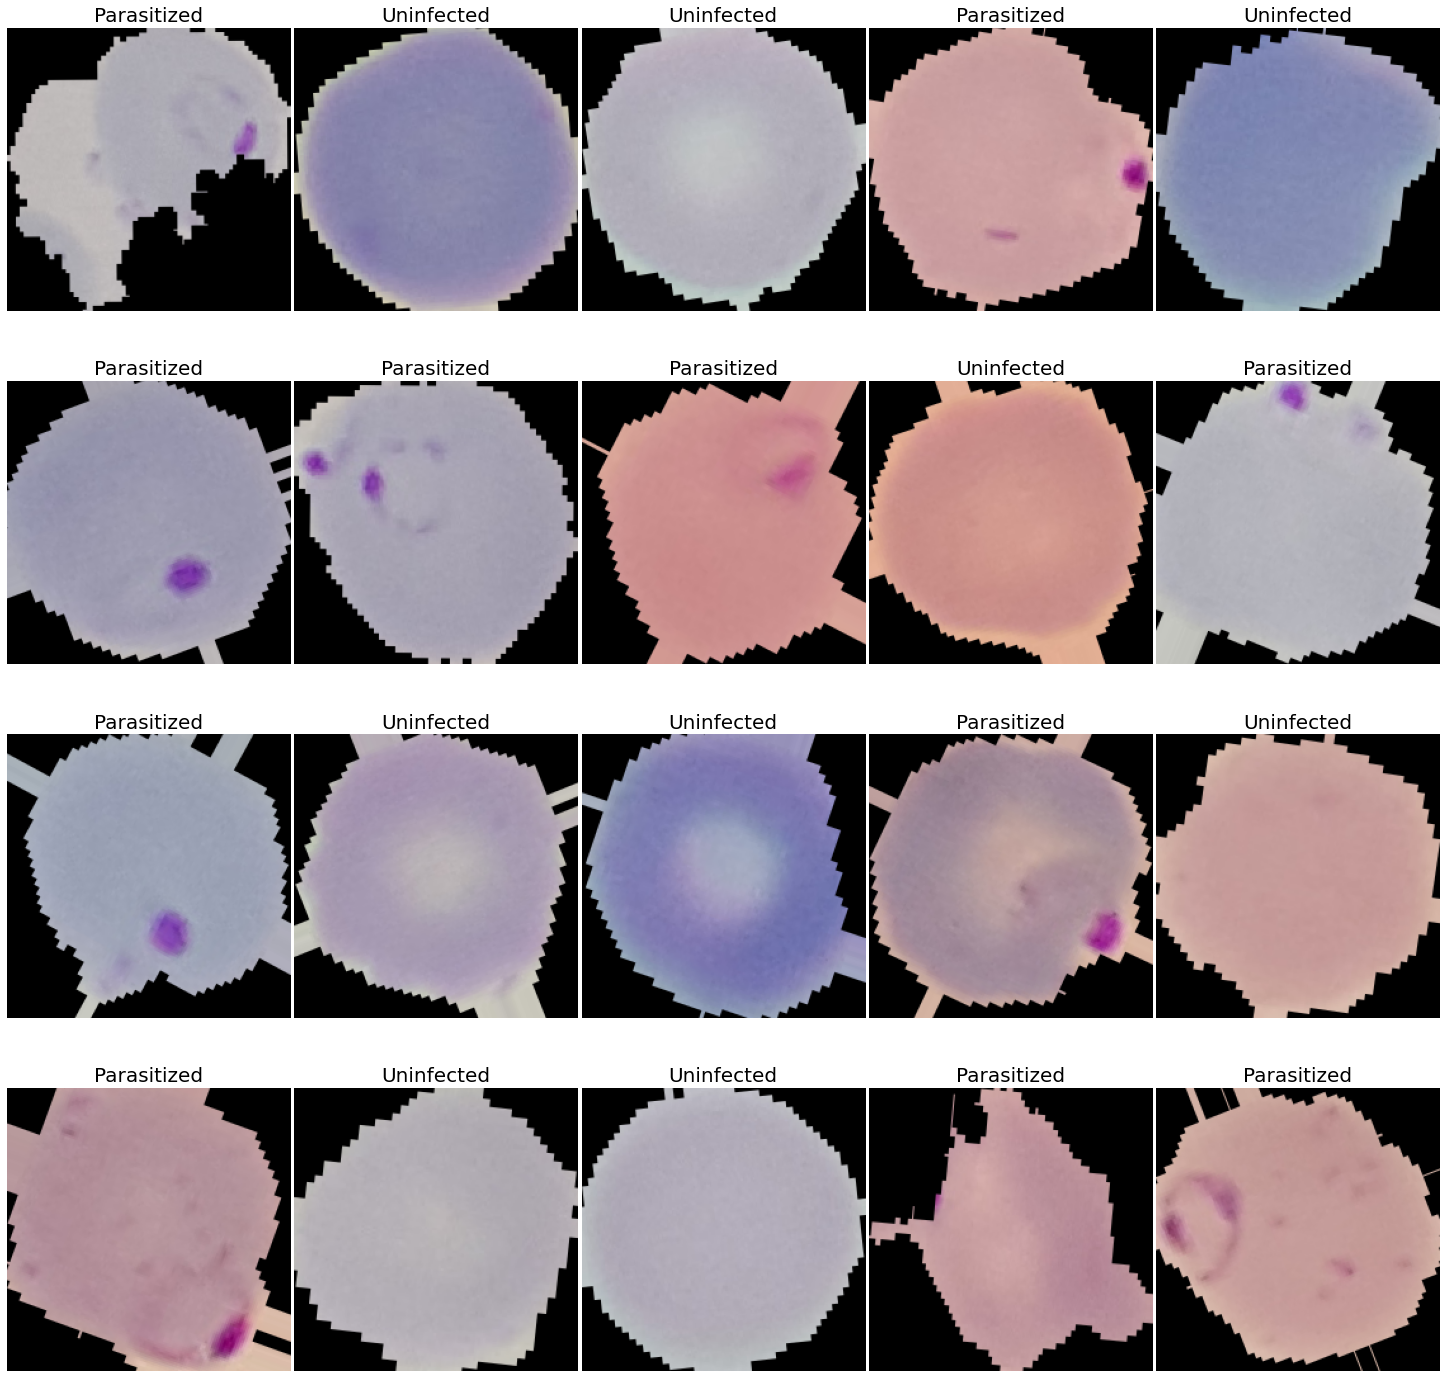

In [214]:
showImages(imgs, labels)

# Build Model

In [234]:
model = tf.keras.models.Sequential([Conv2D(input_shape = (224, 224, 3), filters = 32, kernel_size = (3,3), activation = 'relu'),
                                    MaxPool2D(pool_size = (2,2)),
                                    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'),
                                    MaxPool2D(pool_size = (2,2)),
                                    Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding='same'),
                                    MaxPool2D(pool_size = (2,2), strides = 2),
                                    Flatten(),
                                    Dense(64, activation='relu'),
                                    Dense(1, activation='sigmoid')])

In [235]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 54, 54, 128)       73856     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 27, 27, 128)       0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 93312)           

In [236]:
model.compile(optimizer = Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [237]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [238]:
history = model.fit(train_generator,
                     epochs=10,
                     verbose=1,
                     batch_size = 64,
                     validation_data = val_generator,
                     callbacks = [callback])

Epoch 1/10
827/827 [==============================] - 969s 1s/step - loss: 0.5331 - accuracy: 0.7520 - val_loss: 0.2458 - val_accuracy: 0.9289
Epoch 2/10
827/827 [==============================] - 1859s 2s/step - loss: 0.2031 - accuracy: 0.9362 - val_loss: 0.1813 - val_accuracy: 0.9378
Epoch 3/10
827/827 [==============================] - 1106s 1s/step - loss: 0.1631 - accuracy: 0.9521 - val_loss: 0.1650 - val_accuracy: 0.9439
Epoch 4/10
827/827 [==============================] - 1177s 1s/step - loss: 0.1511 - accuracy: 0.9527 - val_loss: 0.1893 - val_accuracy: 0.9323
Epoch 5/10
827/827 [==============================] - 999s 1s/step - loss: 0.1455 - accuracy: 0.9541 - val_loss: 0.1819 - val_accuracy: 0.9480
Epoch 6/10
827/827 [==============================] - 997s 1s/step - loss: 0.1363 - accuracy: 0.9570 - val_loss: 0.2153 - val_accuracy: 0.9417


In [239]:
model.evaluate(test_generator)

345/345 [==============================] - 165s 477ms/step - loss: 0.1894 - accuracy: 0.9492


[0.18941396474838257, 0.9491869807243347]

In [230]:
model.evaluate(test_generator)

345/345 [==============================] - 147s 426ms/step - loss: 0.1701 - accuracy: 0.9483


[0.17014729976654053, 0.9483159184455872]

### Accuracy Tests

Becuase of the way CNN models operate, I ran through the model multiple times to ensure I was able to get consistent results.

**Model accuracy run 1: 0.9501**

**Model accuracy run 2: 0.9483**

**Model accuracy run 3: 0.9492**

### Test Case Information

Tested using SGD optimizer instead of Adam. Accuracy results were much lower.

# Make Predictions

In [240]:
def showImagesPred(images_arr, labels, predictions):
    fig, axes = plt.subplots(4, 5, figsize=(20,20))
    axes = axes.flatten()
    r = 0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = labels[0 + r]
        pred = predictions[0 + r]
        if pred == 0:
            title = 'Predicted Uninfected'
        else:
            title = 'Predicted Parasitized'
        ax.set_title(title, fontsize=15)
        r +=1
    plt.tight_layout(pad=0.4, )
    plt.show()

In [242]:
u_imgs, u_labels = next(test_generator)

In [243]:
predicted = model.predict(x = test_generator)

In [244]:
pred_images = np.round(predicted);

# Predictions

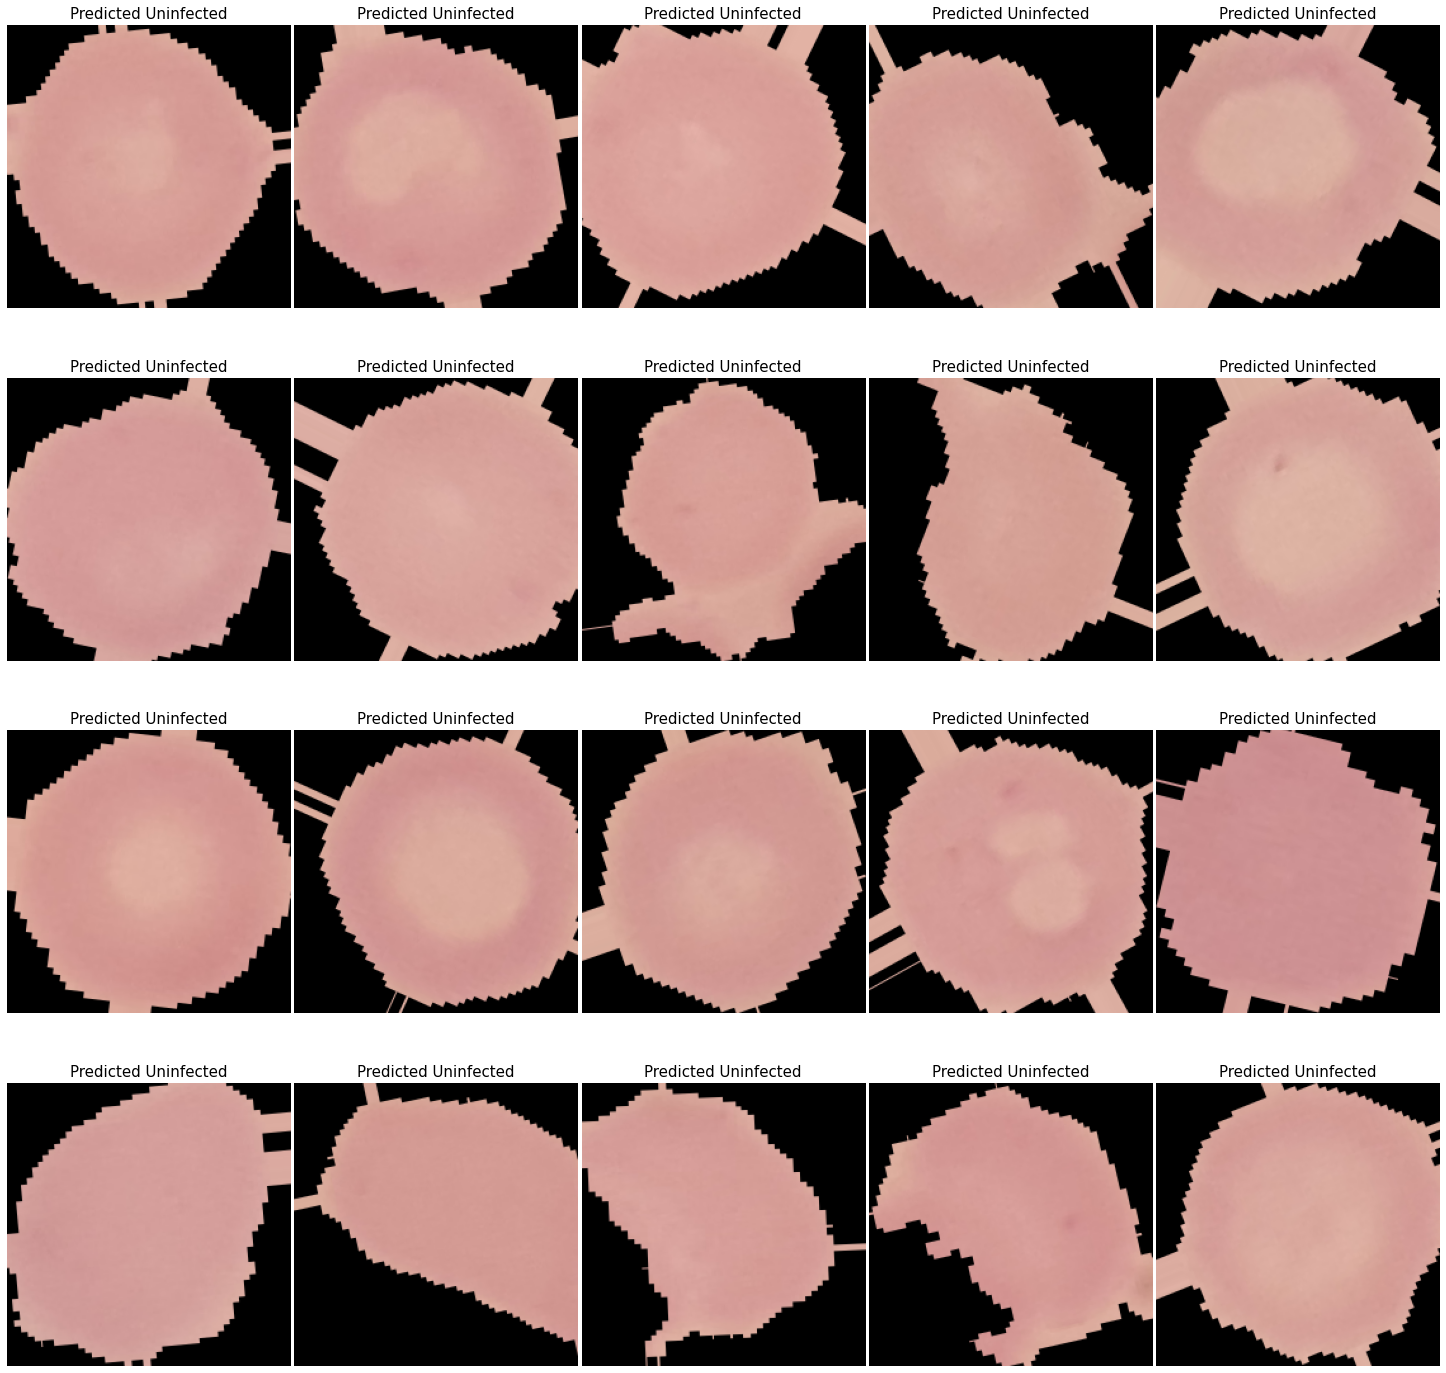

In [245]:
showImagesPred(u_imgs, u_labels, pred_images)